In [1]:
import pandas as pd
import sys
import numpy as np
from tqdm import tqdm
import ast 

sys.path.append('../src')
from SequenceDataLoader import SequenceDataLoader

# update local libraries automatically
%load_ext autoreload
%autoreload 2

In [2]:
# fishnet = Fishnet.load('../Outputs/Test/fishnet_test.pkl')
df = pd.read_csv('../Outputs/Test/urbanization_test.csv')
df.head()

# Create a dictionary

,tile_id,batch_id,year,urbanization_rate,urbanization,ImageCoordinates,Lat,Lon
0,0,0,2017,0.0,0.0,"(0, 0, 49, 40)",36.869991,-80.170884
1,0,0,2018,0.0,0.0,NaN,36.869991,-80.170884
2,0,0,2019,0.0,0.0,NaN,36.869991,-80.170884
3,0,0,2020,0.0,0.0,NaN,36.869991,-80.170884
4,0,0,2021,0.0,0.0,NaN,36.869991,-80.170884


In [3]:
# show more rows
pd.set_option('display.max_rows', 1000)

df.head(1000)
df.ImageCoordinates.isna().sum()

1645745

# Prepare the train set

In [4]:
labels = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
filename = "landcover_batchID_"
list_IDs = [filename + str(s) for s in df["batch_id"].unique()]

# Iterate over the DataFrame and group tile IDs based on batch IDs
tile_region_dic = {}
data = df[df.year == 2017]
for _, row in tqdm(data.iterrows(), total=len(data)):
    batch_id = int(row["batch_id"])
    tile_id = int(row["tile_id"])
    key = filename + str(batch_id)
    if batch_id not in tile_region_dic:
        tile_region_dic[batch_id] = []
    tile_region_dic[batch_id].append(tile_id)

# rename the keys of the dictionary to match the list_IDs
tile_region_dic = {filename + str(k): v for k, v in tile_region_dic.items()}

# Get the urbanization data for each fishnet
YEAR = 2022
TARGET = "urbanization"
fishnet_urbanization = {}
data = df[df.year == YEAR][["tile_id", TARGET]]
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    fishnet_urbanization[int(row["tile_id"])] = row[TARGET]

# Get the coordinate of each fishnet within each region
YEAR = 2017
TARGET = "ImageCoordinates"
tile_coordinates = {}
data = df[df.year == YEAR][["tile_id", TARGET]]
data[TARGET] = data[TARGET].apply(ast.literal_eval)
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    tile_coordinates[int(row["tile_id"])] = row[TARGET]

# Other inputs
train_dir = "../Images/Test"
dim = (40, 44)

100%|██████████| 329149/329149 [00:03<00:00, 88921.22it/s]


In [5]:
# Initialize the SequenceDataLoader for training data
train_data_loader = SequenceDataLoader(
    labels,
    list_IDs,
    fishnet_urbanization, # y: target variable
    tile_region_dic,
    tile_coordinates,
    train_dir,
    dim=dim,
    batch_size=1,
    n_channels=1,
    shuffle=True,
)

In [6]:
X, y = train_data_loader[0]
print(X.shape)
print(y.shape)

(4096, 7, 40, 44, 1)
(4096,)


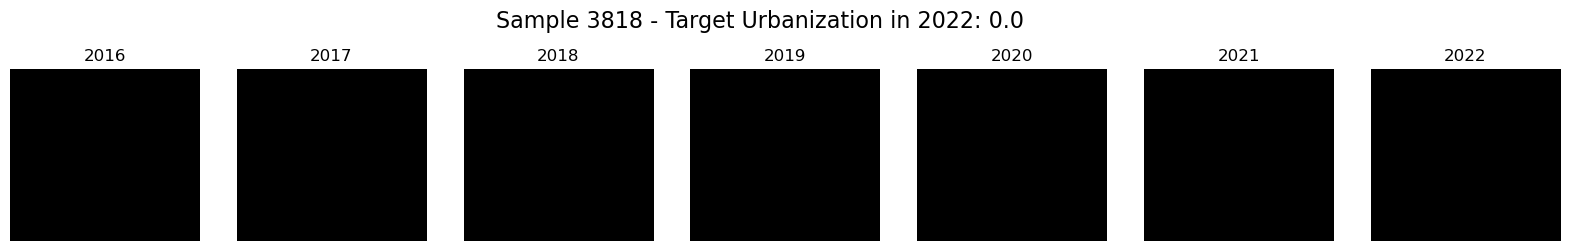

In [7]:
# print 7 images for one specific year for one random sample with seaborn
import matplotlib.pyplot as plt
import seaborn as sns

idx = np.random.randint(0, X.shape[0])
fig, axs = plt.subplots(1, 7, figsize=(20, 3))

fig.suptitle('Sample ' + str(idx) + f" - Target Urbanization in 2022: {y[idx]}", fontsize=16)

for i in range(7):
    axs[i].imshow(X[idx, i, :, :, :], cmap='gray')
    axs[i].set_title(labels[i])
    axs[i].axis('off')
plt.show()

<Axes: ylabel='Count'>

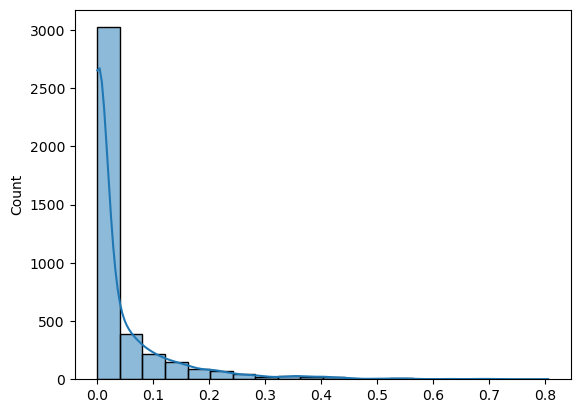

In [8]:
# plot the distribution of y
sns.histplot(y, bins=20, kde=True)

In [9]:
# Test the data loader in a training loop
num_epochs = 2

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for batch_index in range(3):
        print(batch_index)
        X_batch,y = train_data_loader[batch_index]  # Get the batch input data (X) from the data_loader
        print(f"Batch {batch_index+1}/{len(train_data_loader)}, X_batch shape: {X_batch.shape}, y shape: {y.shape}")
        # Here, you can use X_batch to train your model or perform any other processing

Epoch 1/2
0
Batch 1/84, X_batch shape: (4096, 7, 40, 44, 1), y shape: (4096,)
1
Batch 2/84, X_batch shape: (4096, 7, 40, 44, 1), y shape: (4096,)
2
Batch 3/84, X_batch shape: (4096, 7, 40, 44, 1), y shape: (4096,)
Epoch 2/2
0
Batch 1/84, X_batch shape: (4096, 7, 40, 44, 1), y shape: (4096,)
1
Batch 2/84, X_batch shape: (4096, 7, 40, 44, 1), y shape: (4096,)
2
Batch 3/84, X_batch shape: (4096, 7, 40, 44, 1), y shape: (4096,)
